<a href="https://colab.research.google.com/github/saincoder404/Machine-Learning/blob/main/Zomato_Dataset_Analysis_%26_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'zomato-bangalore-restaurants:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F153420%2F352891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T104711Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0fe7923ca0a097e6ce464dc7d24d80804dc13243e29d1f6feac57da024a1c88547f9f6f82a5cbfbdc5913f4b354404c755aa804e40ad29c2422b3027c65f6ea64aded7627640c21119b66e4cd384f9ba8e71f1eee752290dbbfc22e3949c42f08ca26c872e4e3dc70e6cf000c0ac883bd234f405028021598da34af9861651bcdd479913776d278ddb26507de9d268fb98965fc934ab09b67c9bbb580df630374cb38e7a5cf5e18c1dd072d9303803ebdd6c83f9ce9f883d4838391058a3ac7c4047dc298cd4a5060e9daa44b860902363366352c591f8cfc76e7f43aac7b8da6954fbdb2ce6d35a1561aec443e3d9e2c32c3e81a1bd1ebff5fe6d46ce2cb13d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 93341357 bytes downloaded
Downloaded and uncompressed: zomato-bangalore-restaurants
Data source import complete.


*****Zomato Dataset Analysis & Visualization*****

*****import libraries*****

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Check available styles
print(plt.style.available)

# Use 'dark_background' style
plt.style.use('dark_background')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


***Read file***

In [3]:
df = pd.read_csv('/kaggle/input/zomato-bangalore-restaurants/zomato.csv')
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
df.shape

(51717, 17)

In [5]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [6]:
df = df.drop(['url', 'address', 'phone', 'menu_item', 'dish_liked', 'reviews_list','listed_in(city)'], axis = 1)

In [7]:
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type)
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         51717 non-null  object
 1   online_order                 51717 non-null  object
 2   book_table                   51717 non-null  object
 3   rate                         43942 non-null  object
 4   votes                        51717 non-null  int64 
 5   location                     51696 non-null  object
 6   rest_type                    51490 non-null  object
 7   cuisines                     51672 non-null  object
 8   approx_cost(for two people)  51371 non-null  object
 9   listed_in(type)              51717 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.9+ MB


***Dropping Duplicate***

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.shape

(35011, 10)

***Cleaning rate column***

In [11]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

***Removing "New", "-" and "/5" from rate column***

In [12]:
def handlerate(value):
    if value == "NEW" or value == "-":
        return np.nan
    else:
        value = str(value).split('/')
        value = value[0]
        return float(value)

df['rate'] = df['rate'].apply(handlerate)
df['rate'].head(10)

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
5    3.8
6    3.6
7    4.6
8    4.0
9    4.2
Name: rate, dtype: float64

***Fill null values in rate column with Mean***

In [13]:
df['rate'].isnull().sum()

5097

In [14]:
df['rate'].fillna(df['rate'].mean(), inplace = True)
df['rate'].isnull().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35011 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         35011 non-null  object 
 1   online_order                 35011 non-null  object 
 2   book_table                   35011 non-null  object 
 3   rate                         35011 non-null  float64
 4   votes                        35011 non-null  int64  
 5   location                     34997 non-null  object 
 6   rest_type                    34855 non-null  object 
 7   cuisines                     34978 non-null  object 
 8   approx_cost(for two people)  34790 non-null  object 
 9   listed_in(type)              35011 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 2.9+ MB


***Droping null values***

In [16]:
df.dropna(inplace = True)
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet


In [17]:
# rename lengthy column name
df.rename(columns = {'approx_cost(for two people)':'Cost2plates', 'listed_in(type)':'Type'}, inplace = True)
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet


In [18]:
df['location'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Sarjapur Road', 'Whitefield', 'East Bangalore',
       'Old Airport Road', 'Indiranagar', 'Koramangala 1st Block',
       'Frazer Town', 'RT Nagar', 'MG Road', 'Brigade Road',
       'Lavelle Road', 'Church Street', 'Ulsoor', 'Residency Road',
       'Shivajinagar', 'Infantry Road', 'St. Marks Road',
       'Cunningham Road', 'Race Course Road', 'Commercial Street',
       'Vasanth Nagar', 'HBR Layout', 'Domlur', 'Ejipura',
       'Jeeva

In [19]:
df['Cost2plates'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '80', '1,100', '160',
       '1,600', '230', '130', '50', '190', '1,700', '1,400', '180',
       '1,350', '2,200', '2,000', '1,800', '1,900', '330', '2,500',
       '2,100', '3,000', '2,800', '3,400', '40', '1,250', '3,500',
       '4,000', '2,400', '2,600', '120', '1,450', '469', '70', '3,200',
       '60', '560', '240', '360', '6,000', '1,050', '2,300', '4,100',
       '5,000', '3,700', '1,650', '2,700', '4,500', '140'], dtype=object)

***Removing "," from the Cost2plates column***

In [20]:
def removecomma(value):
    value = str(value)
    if ',' in value:
        value = value.replace(',','')
        return float(value)
    else:
        return float(value)

df['Cost2plates'] = df['Cost2plates'].apply(removecomma)
df['Cost2plates'].unique()

array([ 800.,  300.,  600.,  700.,  550.,  500.,  450.,  650.,  400.,
        900.,  200.,  750.,  150.,  850.,  100., 1200.,  350.,  250.,
        950., 1000., 1500., 1300.,  199.,   80., 1100.,  160., 1600.,
        230.,  130.,   50.,  190., 1700., 1400.,  180., 1350., 2200.,
       2000., 1800., 1900.,  330., 2500., 2100., 3000., 2800., 3400.,
         40., 1250., 3500., 4000., 2400., 2600.,  120., 1450.,  469.,
         70., 3200.,   60.,  560.,  240.,  360., 6000., 1050., 2300.,
       4100., 5000., 3700., 1650., 2700., 4500.,  140.])

In [21]:
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,Buffet


***Clean res type of columns***

In [22]:
df['rest_type'].value_counts()

rest_type
Quick Bites                   12123
Casual Dining                  7533
Cafe                           2578
Delivery                       1502
Dessert Parlor                 1491
                              ...  
Pop Up                            1
Quick Bites, Kiosk                1
Mess, Quick Bites                 1
Dessert Parlor, Food Court        1
Sweet Shop, Dessert Parlor        1
Name: count, Length: 93, dtype: int64

In [23]:
rest_types = df['rest_type'].value_counts(ascending = False)
rest_types

rest_type
Quick Bites                   12123
Casual Dining                  7533
Cafe                           2578
Delivery                       1502
Dessert Parlor                 1491
                              ...  
Pop Up                            1
Quick Bites, Kiosk                1
Mess, Quick Bites                 1
Dessert Parlor, Food Court        1
Sweet Shop, Dessert Parlor        1
Name: count, Length: 93, dtype: int64

In [24]:
rest_types_lessthan1000 = rest_types[rest_types<1000]
rest_types_lessthan1000

rest_type
Casual Dining, Bar            949
Bakery                        736
Beverage Shop                 487
Bar                           473
Food Court                    424
                             ... 
Pop Up                          1
Quick Bites, Kiosk              1
Mess, Quick Bites               1
Dessert Parlor, Food Court      1
Sweet Shop, Dessert Parlor      1
Name: count, Length: 87, dtype: int64

***Making rest types less than 1000 in frequency as others***

In [25]:
def handle_rest_type(value):
    if(value in rest_types_lessthan1000):
        return 'other'
    else:
        return value

df['rest_type'] = df['rest_type'].apply(handle_rest_type)
df['rest_type'].value_counts()

rest_type
Quick Bites           12123
other                  8193
Casual Dining          7533
Cafe                   2578
Delivery               1502
Dessert Parlor         1491
Takeaway, Delivery     1216
Name: count, dtype: int64

***Clean location column***

In [26]:
df['location'].value_counts()

location
BTM                     2484
Whitefield              1945
HSR                     1753
Indiranagar             1747
Marathahalli            1649
                        ... 
Yelahanka                  5
Nagarbhavi                 4
Rajarajeshwari Nagar       2
Jakkur                     1
Peenya                     1
Name: count, Length: 93, dtype: int64

In [27]:
location = df['location'].value_counts(ascending = False)
location_lessthan300 = location[location<300]

In [28]:
def handle_location(value):
    if(value in location_lessthan300):
        return 'other'
    else:
        return value

df['location'] = df['location'].apply(handle_location)
df['location'].value_counts()

location
other                    4838
BTM                      2484
Whitefield               1945
HSR                      1753
Indiranagar              1747
Marathahalli             1649
Koramangala 5th Block    1605
JP Nagar                 1400
Jayanagar                1242
Electronic City          1212
Bellandur                1120
Bannerghatta Road        1052
Sarjapur Road             933
Brigade Road              687
Koramangala 7th Block     624
Brookefield               598
Koramangala 6th Block     590
Koramangala 4th Block     587
Kalyan Nagar              584
New BEL Road              582
Banashankari              571
Malleshwaram              556
MG Road                   554
Ulsoor                    546
Koramangala 1st Block     539
Frazer Town               469
Basavanagudi              463
Rajajinagar               462
Church Street             446
Banaswadi                 427
Residency Road            423
Kammanahalli              417
Old Airport Road          401
L

***Clean Cuisines column***

In [29]:
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,other,"Cafe, Mexican, Italian",800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,Buffet


In [30]:
df['cuisines'].value_counts()

cuisines
North Indian                                   1895
North Indian, Chinese                          1561
South Indian                                   1172
Bakery, Desserts                                591
Biryani                                         557
                                               ... 
Salad, Juices                                     1
Pizza, Italian, Chinese, Rolls, Biryani           1
Burger, Juices                                    1
North Indian, Fast Food, Biryani, Beverages       1
North Indian, Chinese, Arabian, Momos             1
Name: count, Length: 2704, dtype: int64

In [31]:
cuisines = df['cuisines'].value_counts(ascending = False)
cuisines_lessthan100 = cuisines[cuisines<100]

In [32]:
def handle_cuisines(value):
    if(value in cuisines_lessthan100):
        return 'other'
    else:
        return value

df['cuisines'] = df['cuisines'].apply(handle_cuisines)
df['cuisines'].value_counts()

cuisines
other                                               19621
North Indian                                         1895
North Indian, Chinese                                1561
South Indian                                         1172
Bakery, Desserts                                      591
Biryani                                               557
Fast Food                                             485
South Indian, North Indian, Chinese                   475
Desserts                                              447
Cafe                                                  447
Bakery                                                385
Chinese                                               337
Ice Cream, Desserts                                   304
Mithai, Street Food                                   256
Chinese, North Indian                                 249
North Indian, Chinese, Biryani                        234
Desserts, Ice Cream                                   226
North

In [33]:
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,Cost2plates,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,other,800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,other,800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,other,other,800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,other,600.0,Buffet


In [34]:
df['Type'].value_counts()

Type
Delivery              15995
Dine-out              12783
Desserts               2452
Cafes                  1238
Drinks & nightlife      902
Buffet                  669
Pubs and bars           597
Name: count, dtype: int64

***Now Data is clean, Lets jump to visualization***

***Counts plot of different locations***

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, 'other'),
  Text(1, 0, 'BTM'),
  Text(2, 0, 'Whitefield'),
  Text(3, 0, 'HSR'),
  Text(4, 0, 'Indiranagar'),
  Text(5, 0, 'Marathahalli'),
  Text(6, 0, 'Koramangala 5th Block'),
  Text(7, 0, 'JP Nagar'),
  Text(8, 0, 'Jayanagar'),
  Text(9, 0, 'Electronic City'),
  Text(10, 0, 'Bellandur'),
  Text(11, 0, 'Bannerghatta Road'),
  Text(12, 0, 'Sarjapur Road'),
  Text(13, 0, 'Brigade Road'),
  Text(14, 0, 'Koramangala 7th Block'),
  Text(15, 0, 'Brookefield'),
  Text(16, 0, 'Koramangala 6th Block'),
  Text(17, 0, 'Koramangala 4th Block'),
  Text(18, 0, 'Kalyan Nagar'),
  Text(19, 0, 'New BEL Road'),
  Text(20, 0, 'Banashankari'),
  Text(21, 0, 'Malleshwaram'),
  Text(22, 0, 'MG Road'),
  Text(23, 0, 'Ulsoor'),
  Text(24, 0, 'Koramangala 1st Block'),
  Text(25, 0, 'Frazer To

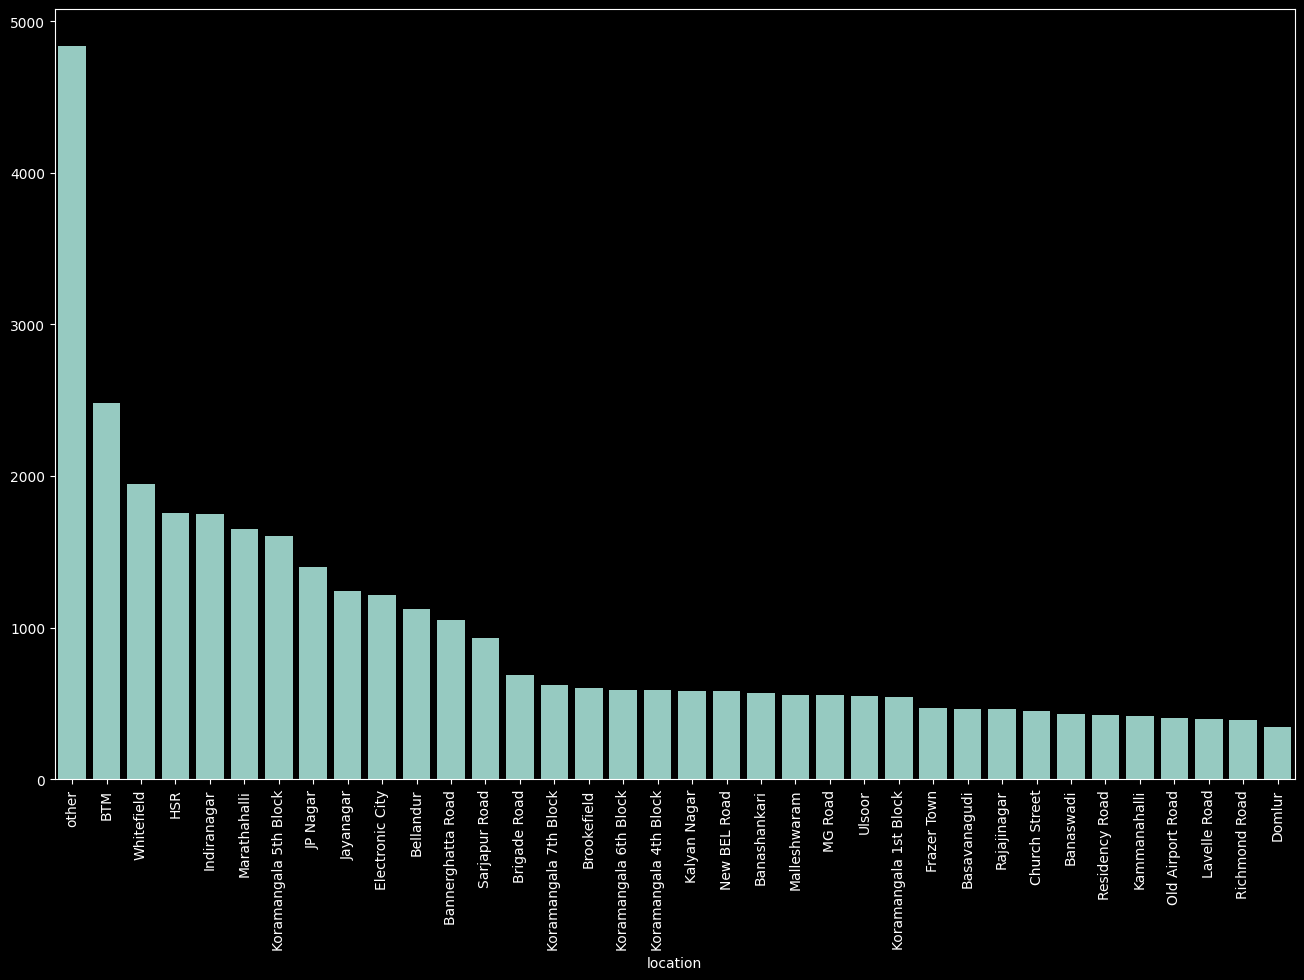

In [35]:
plt.figure(figsize=(16, 10))
location_counts = df['location'].value_counts()
ax = sns.barplot(x=location_counts.index, y=location_counts.values)
plt.xticks(rotation=90)

***Visualizing Online Order***

<ipython-input-36-e8145e865d83>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_counts.index, y=order_counts, palette='inferno')


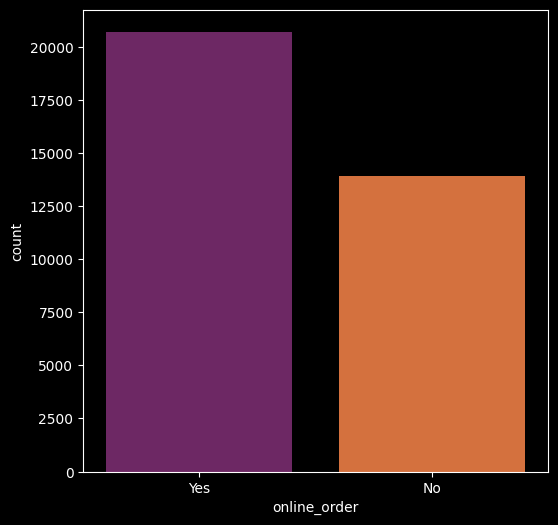

In [36]:
plt.figure(figsize = (6,6))
order_counts = df['online_order'].value_counts()  # Count the occurrences in 'online_order'

sns.barplot(x=order_counts.index, y=order_counts, palette='inferno')
plt.show()

***Visualizing Book Table***

<ipython-input-37-0a22607c61f0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_counts.index, y=order_counts, palette='rainbow')


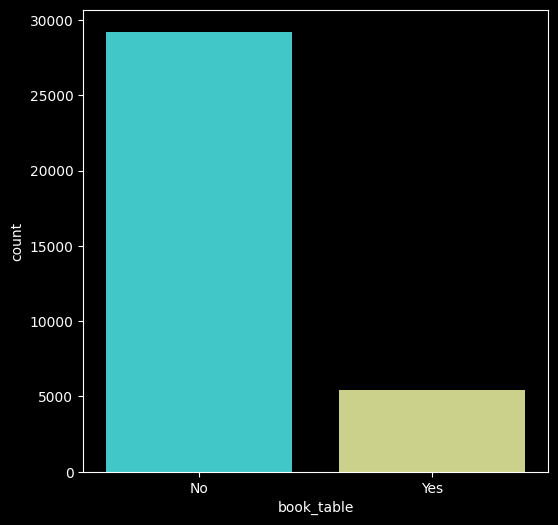

In [37]:
plt.figure(figsize = (6,6))
order_counts = df['book_table'].value_counts()

sns.barplot(x=order_counts.index, y=order_counts, palette='rainbow')
plt.show()

***Visualizing Online order vs rate***

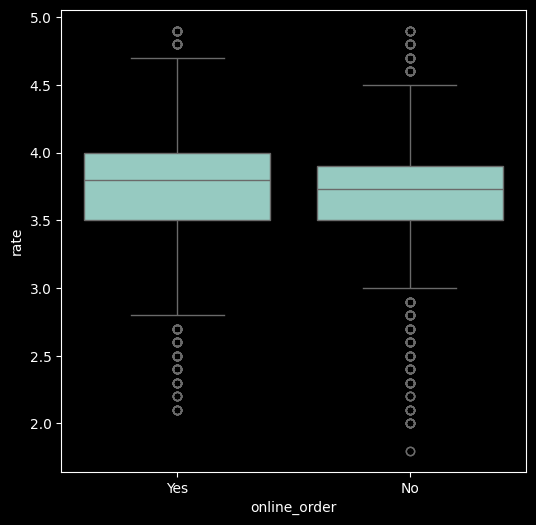

In [38]:
plt.figure(figsize = (6,6))
sns.boxplot(x = 'online_order', y = 'rate', data = df)
plt.show()

***Visualizing Booktable vs rate***

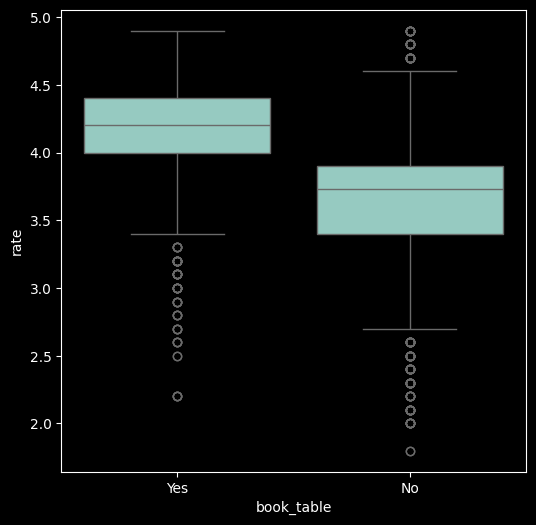

In [39]:
plt.figure(figsize = (6,6))
sns.boxplot(x = 'book_table', y = 'rate', data = df)
plt.show()

***Visualizing Online Order Facilty , Location wiseVisualizing Online Order Facilty , Location wise***

In [40]:
df1 = df.groupby(['location', 'online_order'])['name'].count()
df1.to_csv('location_online.csv')
df1 = pd.read_csv('location_online.csv')
df1 = pd.pivot_table(df1, values = None, index = ['location'], columns = ['online_order'], fill_value = 0, aggfunc = np.sum)
df1

name      
online_order             No   Yes
location                         
BTM                     802  1682
Banashankari            260   311
Banaswadi               208   219
Bannerghatta Road       399   653
Basavanagudi            182   281
Bellandur               437   683
Brigade Road            293   394
Brookefield             206   392
Church Street           182   264
Domlur                  187   158
Electronic City         657   555
Frazer Town             206   263
HSR                     438  1315
Indiranagar             647  1100
JP Nagar                562   838
Jayanagar               380   862
Kalyan Nagar            240   344
Kammanahalli            176   241
Koramangala 1st Block   148   391
Koramangala 4th Block   279   308
Koramangala 5th Block   580  1025
Koramangala 6th Block   211   379
Koramangala 7th Block   190   434
Lavelle Road            237   159
MG Road                 297   257
Malleshwaram            224   332
Marathahalli            628  1021
New BEL Road            250   332
Old Airport Road        201   200
Rajajinagar             214   248
Residency Road          276   147
Richmond Road           249   140
Sarjapur Road           282   651
Ulsoor                  201   345
Whitefield              880  1065
other                  2106  2732

<Axes: xlabel='location'>

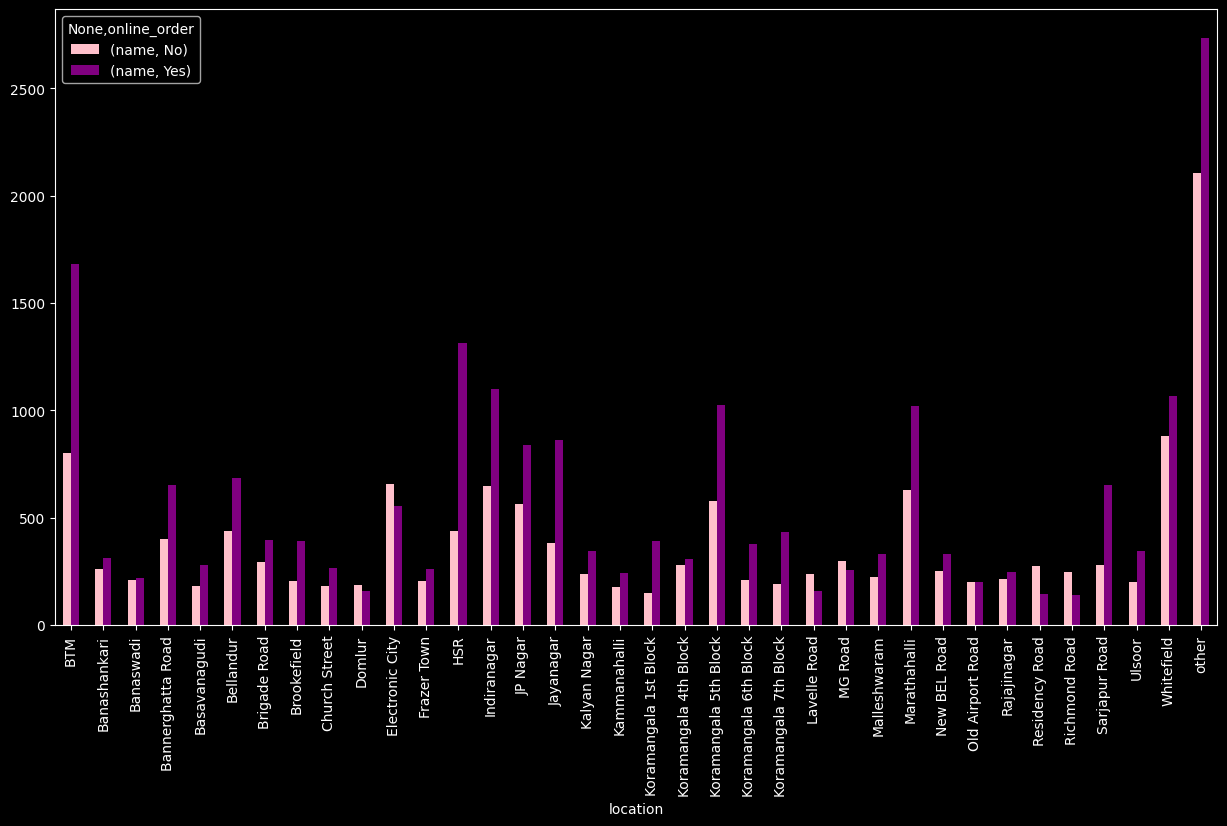

In [41]:
df1.plot(kind='bar', figsize=(15, 8), color=['pink', 'purple'])

***Visualizing Book Table Facilty , Location wise***

In [42]:
df2 = df.groupby(['location', 'book_table'])['name'].count()
df2.to_csv('location_book_table.csv')
df2 = pd.read_csv('location_book_table.csv')
df2 = pd.pivot_table(df2, values = None, index = ['location'], columns = ['book_table'], fill_value = 0, aggfunc = np.sum)
df2

name     
book_table               No  Yes
location                        
BTM                    2358  126
Banashankari            528   43
Banaswadi               421    6
Bannerghatta Road       973   79
Basavanagudi            451   12
Bellandur              1024   96
Brigade Road            541  146
Brookefield             525   73
Church Street           279  167
Domlur                  300   45
Electronic City        1116   96
Frazer Town             461    8
HSR                    1566  187
Indiranagar            1310  437
JP Nagar               1148  252
Jayanagar              1015  227
Kalyan Nagar            466  118
Kammanahalli            383   34
Koramangala 1st Block   497   42
Koramangala 4th Block   340  247
Koramangala 5th Block  1004  601
Koramangala 6th Block   509   81
Koramangala 7th Block   494  130
Lavelle Road            195  201
MG Road                 286  268
Malleshwaram            475   81
Marathahalli           1492  157
New BEL Road            527   55
Old Airport Road        343   58
Rajajinagar             422   40
Residency Road          306  117
Richmond Road           308   81
Sarjapur Road           786  147
Ulsoor                  433  113
Whitefield             1693  252
other                  4259  579

<Axes: xlabel='location'>

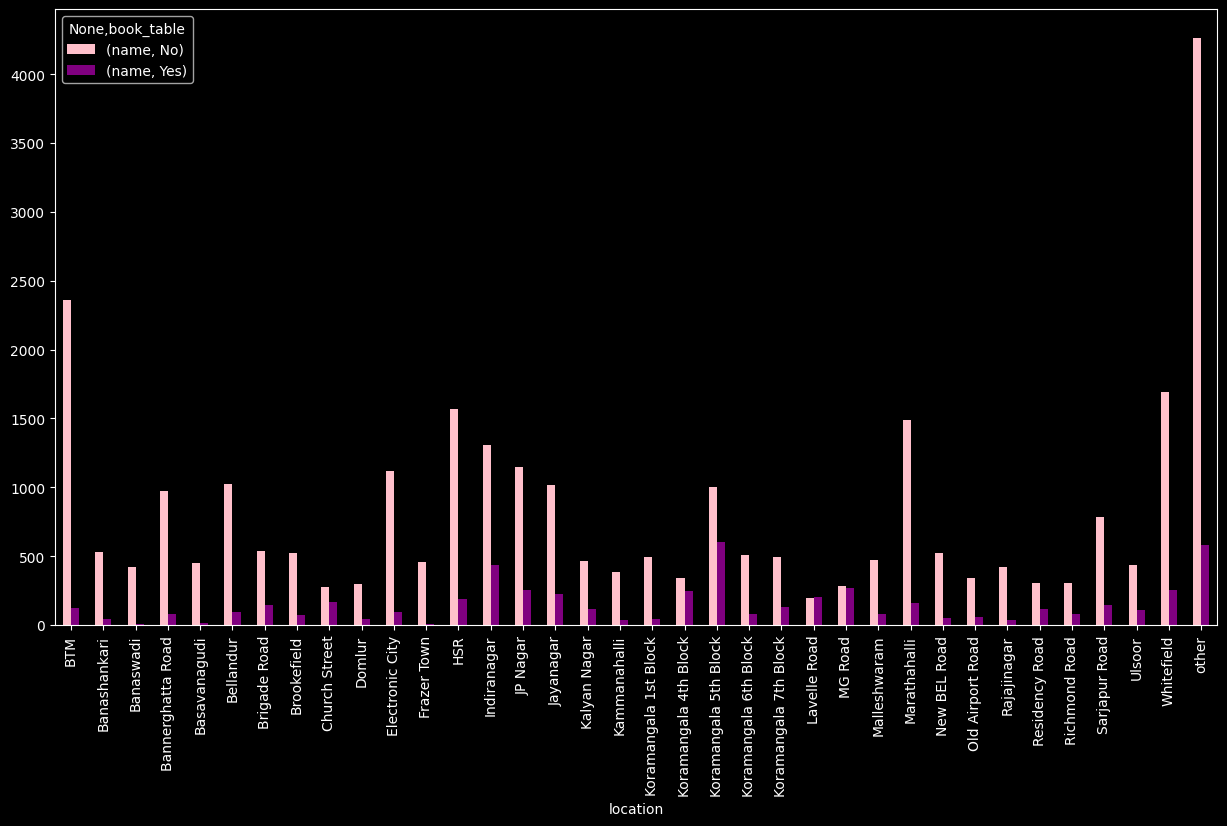

In [43]:
df2.plot(kind='bar', figsize=(15, 8), color=['pink', 'purple'])

***Visualizing Types of Restaurents vs Rate***

<ipython-input-44-48f1c4fedc47>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'Type', y = 'rate', data = df, palette = 'inferno')


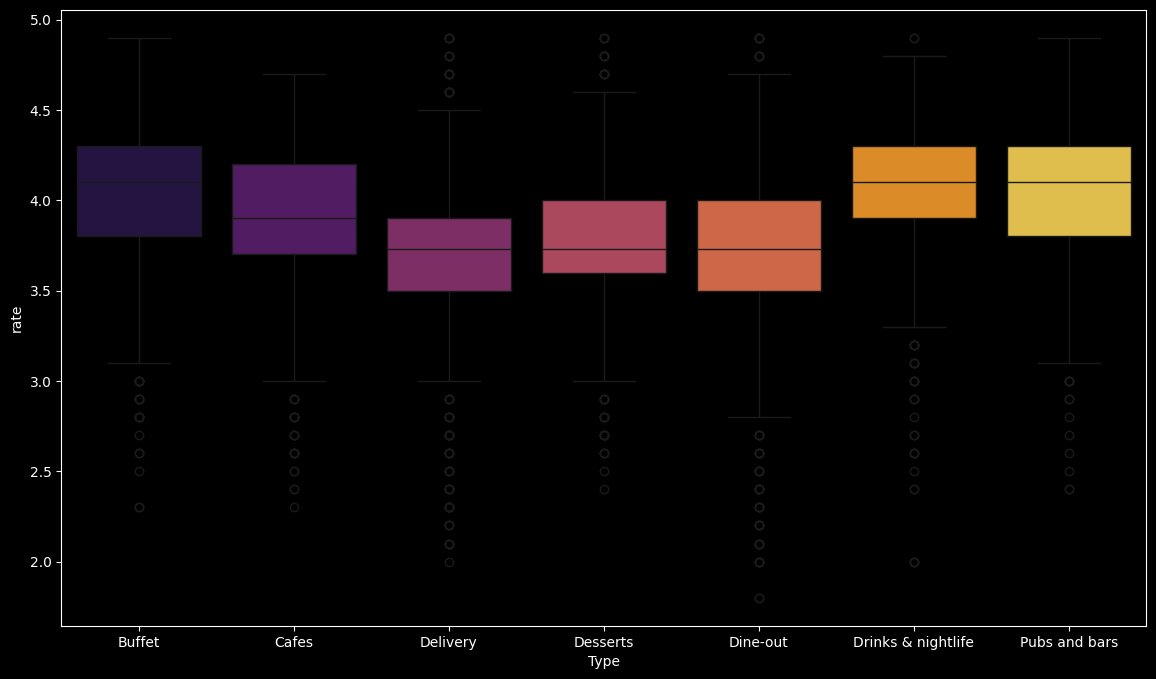

In [44]:
plt.figure(figsize = (14,8))
sns.boxplot(x = 'Type', y = 'rate', data = df, palette = 'inferno')
plt.show()

***Grouping types of Restaurents, location wise***

In [45]:
df3 = df.groupby(['location', 'Type'])['name'].count()
df3.to_csv('location_Type.csv')
df3 = pd.read_csv('location_Type.csv')
df3 = pd.pivot_table(df3, values = None, index = ['location'], columns = ['Type'], fill_value = 0, aggfunc = np.sum)
df3

name                                   \
Type                  Buffet Cafes Delivery Desserts Dine-out   
location                                                        
BTM                       15    46     1418      110      866   
Banashankari               5    24      243       46      246   
Banaswadi                  0    13      157       19      233   
Bannerghatta Road          8    27      510       92      404   
Basavanagudi               4     8      195       45      208   
Bellandur                 28    34      513       70      442   
Brigade Road              13    24      249       55      273   
Brookefield                6    17      299       42      230   
Church Street             19    44      138       21      172   
Domlur                    11    12      168       24      108   
Electronic City           22    24      548       71      505   
Frazer Town                1    10      267       46      141   
HSR                       14    42     1076      108      484   
Indiranagar               38    97      830      136      515   
JP Nagar                  25    41      629      104      554   
Jayanagar                 19    50      560      118      483   
Kalyan Nagar               9    24      188       45      303   
Kammanahalli               2    14      160       18      220   
Koramangala 1st Block      3    14      319       32      156   
Koramangala 4th Block     13    43      249       38      163   
Koramangala 5th Block     51   118      626      135      542   
Koramangala 6th Block     12    30      277       48      180   
Koramangala 7th Block     19    30      247       69      215   
Lavelle Road              24    22       87       28      158   
MG Road                   32    55      138       37      221   
Malleshwaram              11    24      197       63      231   
Marathahalli              34    30      874       94      594   
New BEL Road               4    29      277       33      223   
Old Airport Road          12     5      174       34      155   
Rajajinagar                9     4      196       44      196   
Residency Road            14    19      106       38      186   
Richmond Road             41    13      110       37      172   
Sarjapur Road             23    19      473       78      299   
Ulsoor                    12    32      217       38      216   
Whitefield                28    50      934      128      726   
other                     88   150     2346      308     1763   

                                                        
Type                  Drinks & nightlife Pubs and bars  
location                                                
BTM                                   15            14  
Banashankari                           7             0  
Banaswadi                              4             1  
Bannerghatta Road                      9             2  
Basavanagudi                           3             0  
Bellandur                             17            16  
Brigade Road                          51            22  
Brookefield                            4             0  
Church Street                         31            21  
Domlur                                11            11  
Electronic City                       21            21  
Frazer Town                            2             2  
HSR                                   14            15  
Indiranagar                           65            66  
JP Nagar                              40             7  
Jayanagar                             12             0  
Kalyan Nagar                          15             0  
Kammanahalli                           3             0  
Koramangala 1st Block                  5            10  
Koramangala 4th Block                 50            31  
Koramangala 5th Block                 75            58  
Koramangala 6th Block                 25            18  
Koramangala 7th Block                 22            22  
Lavell

<Axes: xlabel='location'>

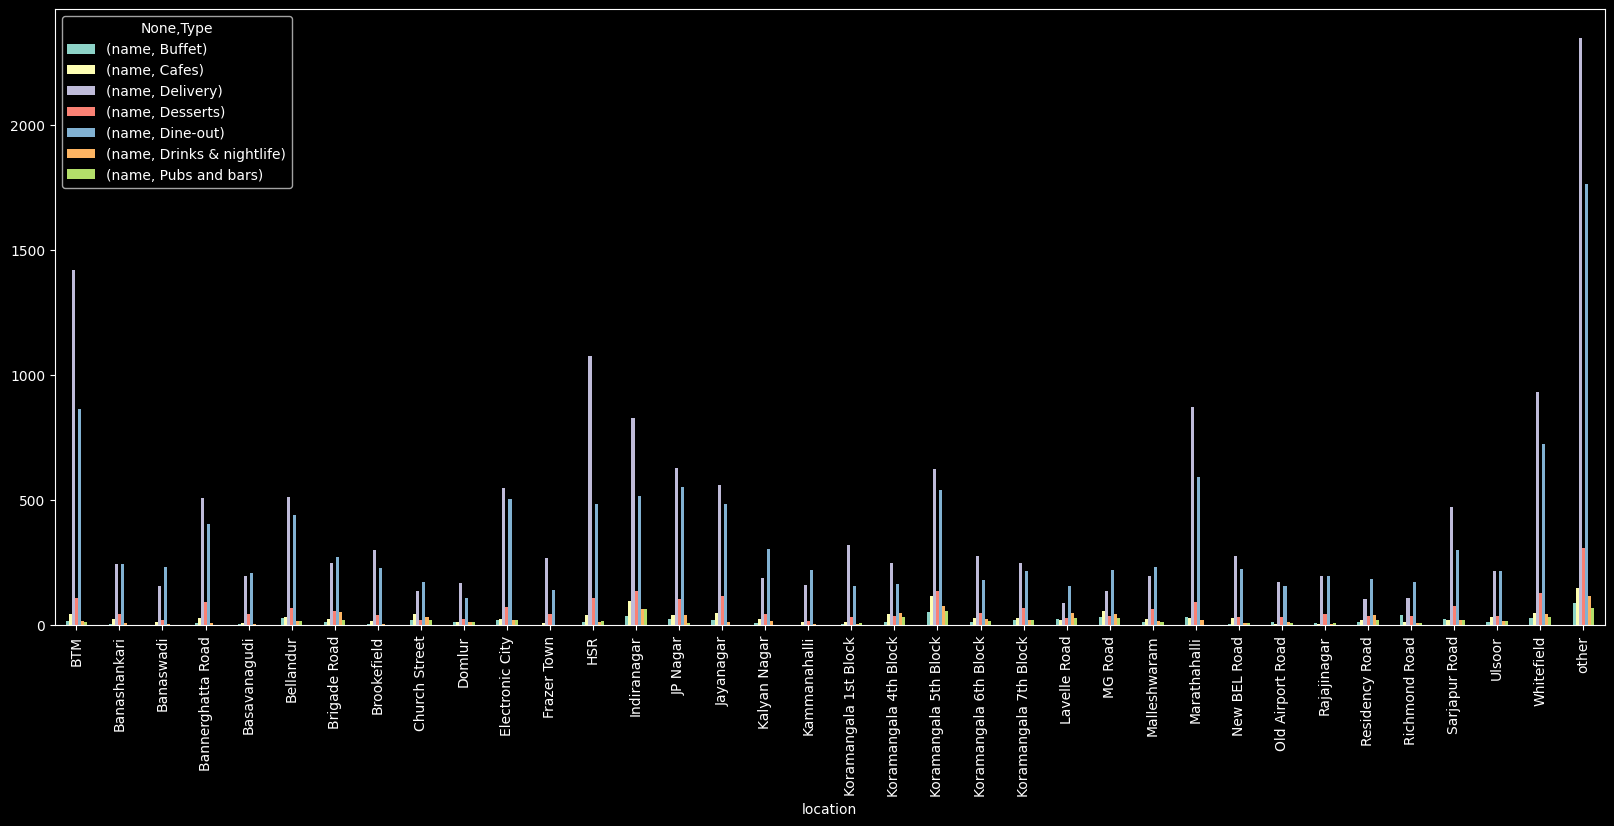

In [46]:
df3.plot(kind='bar', figsize=(20, 8))

***No. of votes, Location wise***

In [47]:
df4 = df[['location', 'votes']]
df4.drop_duplicates()
df5 = df4.groupby(['location'])['votes'].sum()
df5 = df5.to_frame()
df5 = df5.sort_values('votes', ascending = False)
df5.head()

,votes
location,
Koramangala 5th Block,1984132
Indiranagar,1129994
other,1016001
Koramangala 4th Block,591240
Church Street,555228


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, 'Koramangala 5th Block'),
  Text(1, 0, 'Indiranagar'),
  Text(2, 0, 'other'),
  Text(3, 0, 'Koramangala 4th Block'),
  Text(4, 0, 'Church Street'),
  Text(5, 0, 'JP Nagar'),
  Text(6, 0, 'Whitefield'),
  Text(7, 0, 'Lavelle Road'),
  Text(8, 0, 'HSR'),
  Text(9, 0, 'Marathahalli'),
  Text(10, 0, 'Koramangala 7th Block'),
  Text(11, 0, 'BTM'),
  Text(12, 0, 'Jayanagar'),
  Text(13, 0, 'Sarjapur Road'),
  Text(14, 0, 'Brigade Road'),
  Text(15, 0, 'MG Road'),
  Text(16, 0, 'Koramangala 6th Block'),
  Text(17, 0, 'Residency Road'),
  Text(18, 0, 'Malleshwaram'),
  Text(19, 0, 'Bellandur'),
  Text(20, 0, 'Bannerghatta Road'),
  Text(21, 0, 'Koramangala 1st Block'),
  Text(22, 0, 'New BEL Road'),
  Text(23, 0, 'Old Airport Road'),
  Text(24, 0, 'Kalyan Nagar'),
  Text(25, 0,

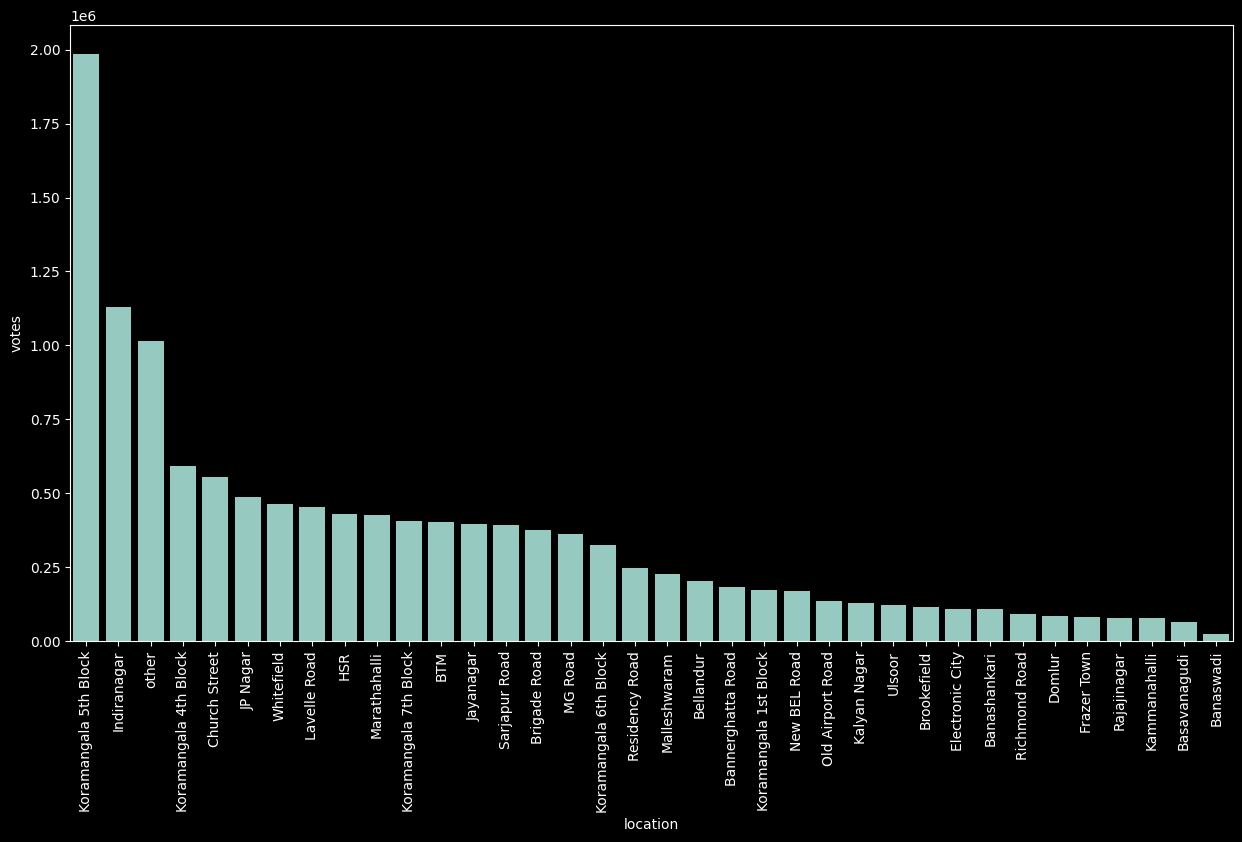

In [48]:
plt.figure(figsize = (15,8))
sns.barplot(x = df5.index, y = df5['votes'])
plt.xticks(rotation = 90)

***Visualizing Top Cuisines***

In [49]:
df6 = df[['cuisines', 'votes']]
df6.drop_duplicates()
df7 = df6.groupby(['cuisines'])['votes'].sum()
df7 = df7.to_frame()
df7 = df7.sort_values('votes', ascending = False)
df7.head()

,votes
cuisines,
other,10498501
North Indian,439263
"North Indian, Chinese",187867
South Indian,130350
"North Indian, Mughlai",88971


In [50]:
df7 = df7.iloc[1:, :]
df7.head()

,votes
cuisines,
North Indian,439263
"North Indian, Chinese",187867
South Indian,130350
"North Indian, Mughlai",88971
Chinese,79450


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52],
 [Text(0, 0, 'North Indian'),
  Text(1, 0, 'North Indian, Chinese'),
  Text(2, 0, 'South Indian'),
  Text(3, 0, 'North Indian, Mughlai'),
  Text(4, 0, 'Chinese'),
  Text(5, 0, 'North Indian, South Indian'),
  Text(6, 0, 'Cafe'),
  Text(7, 0, 'Chinese, Momos'),
  Text(8, 0, 'Desserts'),
  Text(9, 0, 'Ice Cream, Desserts'),
  Text(10, 0, 'Biryani, North Indian, Chinese'),
  Text(11, 0, 'Cafe, Continental'),
  Text(12, 0, 'Finger Food'),
  Text(13, 0, 'Desserts, Beverages'),
  Text(14, 0, 'South Indian, North Indian, Chinese'),
  Text(15, 0, 'Continental'),
  Text(16, 0, 'Burger, Fast Food'),
  Text(17, 0, 'Andhra, Biryani'),
  Text(18, 0, 'Biryani'),
  Text(19, 0, 'Bakery, Desserts'),

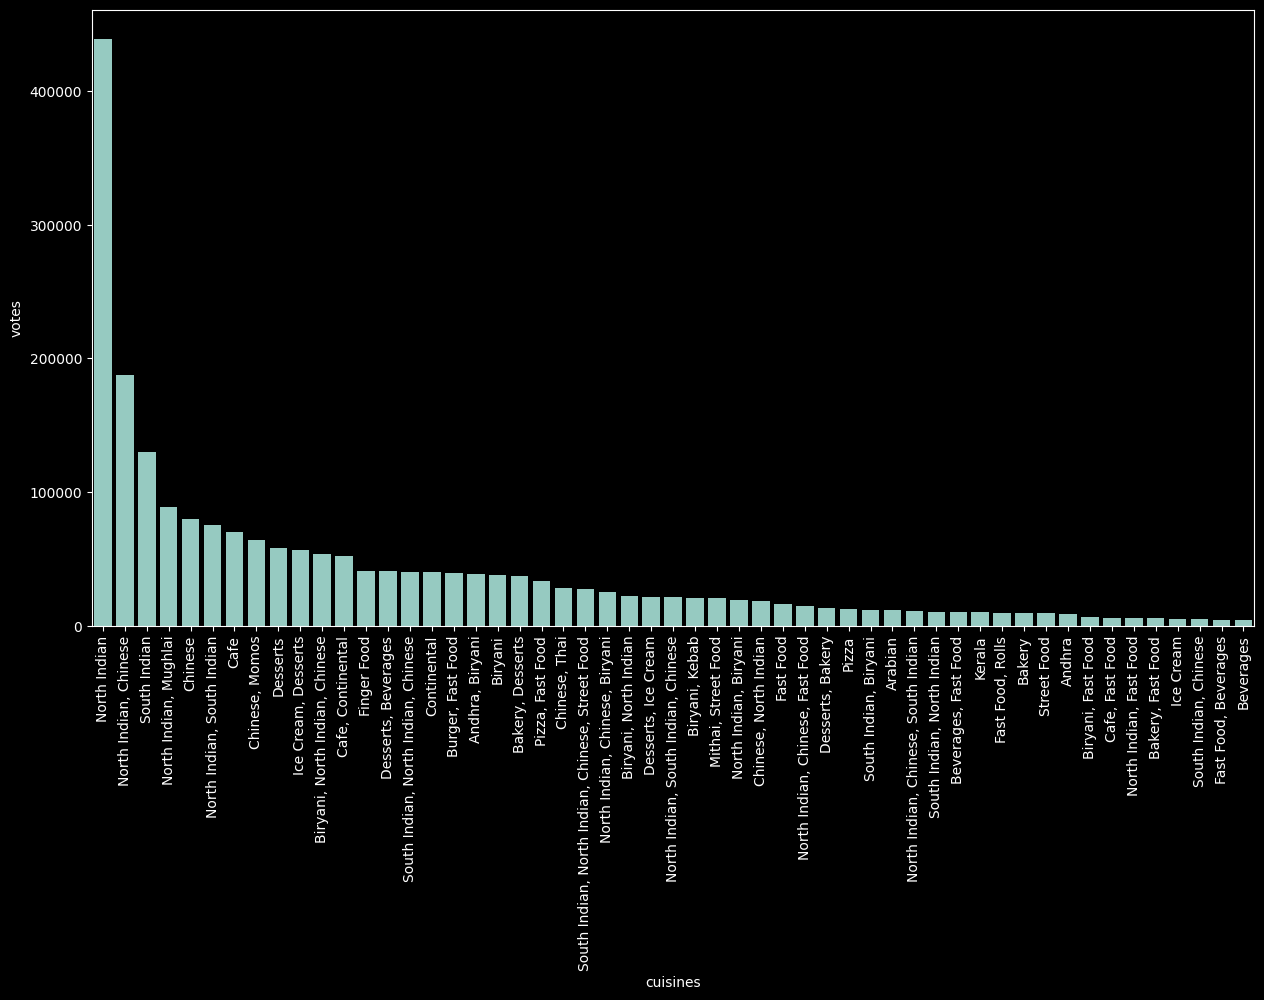

In [51]:
plt.figure(figsize = (15,8))
sns.barplot(x = df7.index, y = df7['votes'])
plt.xticks(rotation = 90)